### Задание 1:
Коллеги из ML-отдела рассказали, что планируют выкатывать новый алгоритм, рекомендующий пользователям интересные посты.

Работает он следующим образом:
1. Алгоритм добавляет пользователям 1-2 просмотра.
2. Вероятность того, что он сработает, составляет 90%.
3. Если у пользователя меньше 50 просмотров, то алгоритм не сработает.

Предполагается, что увеличение числа просмотров приведёт и к увеличению лайков на пользователя.

Вопрос: сможем ли мы обнаружить различия в среднем количестве лайков на пользователя? 

Чтобы ответить на этот вопрос, проведём симуляцию Монте-Карло.

p.s. A/A тест проводился с '2024-03-22' по '2024-03-28'. 

### Общая идея: 
1. Строим распределения показателей по историческим данным (данным A/A теста), от которых зависит целевая метрика, далее из этих распределений сэмплируем выборки фиксированного заранее размера.
2. На основе сэмплированных выборок генерируем 2 группы данных, на которых считаем целевую метрику, причём одной из групп придаём эффект, который хотим увидеть, то есть искусственно делаем её контрольной.
3. Фиксируем параметры, в том числе - количество проведения симуляций, и проводим статистический тест, смотрим на отличия, если они были зафиксированы с нужными параметрами, то данный размер выборок подходит, если же эффект не был замечен, то меняем значения параметров.
4. Повторяем процесс, пока метрика не прокрасится при заранее фиксированных условиях.
#### Заметка
Мощность теста в данном случае определяется как отношение прокрасившихся тестов ко всем тестам, поскольку изменения между группами действительно есть и p-value для обнаружения данного отличия должен быть < 0.05.

In [1]:
import pandahouse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from tqdm import tqdm
%matplotlib inline

#генератор псевдослучайных чисел для сэмплирования
rng = np.random.default_rng()

In [2]:
#здесь были параметры подключения
connection = {
    'host': '...',
    'password': '...',
    'user': '...',
    'database': '...'
}

In [3]:
#эмпирическое распределение просмотров
q = """
    select views, count() as users
    from (select user_id, sum(action = 'view') as views
          from {db}.feed_actions
          where date(time) between date('2024-03-22') and date('2024-03-28')
          group by user_id
          )
    group by views
    order by views
"""

views_distribution = pandahouse.read_clickhouse(q, connection=connection)
views_distribution['p'] = views_distribution['users'] / views_distribution.users.sum()

In [4]:
views_distribution.head()

,views,users,p
0,1,4,0.000095
1,2,1,0.000024
2,3,4,0.000095
3,4,5,0.000119
4,5,18,0.000429


In [5]:
#эмпирическое распределение CTR
q = """
    select floor(ctr, 2) as ctr, count() as users
    from (select user_id, sum(action='like')/sum(action='view') as ctr
          from {db}.feed_actions
          where date(time) between date('2024-03-22') and date('2024-03-28')
          group by user_id
          )
    group by ctr
"""
ctr_distribution = pandahouse.read_clickhouse(q, connection=connection)
ctr_distribution['p'] = ctr_distribution['users'] / ctr_distribution.users.sum()

In [6]:
ctr_distribution.head()

,ctr,users,p
0,0.00,213,0.005072
1,0.65,3,0.000071
2,0.49,5,0.000119
3,0.54,27,0.000643
4,0.23,1914,0.045575


In [7]:
#кол-во пользователей в одной группе 
views_distribution.users.sum() // 2 

20998.0

In [8]:
#функция для сэмплирования
def get_sample(values, n, prob): 
    res = rng.choice(values, size=n, replace=True, p=prob)
    return res

В данной части реализовано сэмплирование CTR и просмотров для обеих групп + придание нужного эффекта контрольной группе, генерация лайков для обеих групп на ранее созданных выборках, а также проведение t-test.

In [9]:
n = 41997//2
sim = 20000
cnt = 0
for _ in tqdm(range(sim)):
    views_A = get_sample(views_distribution.views, n, views_distribution.p).astype('int32')
    views_B = get_sample(views_distribution.views, n, views_distribution.p).astype('int32')
    views_B_before = views_B.copy()
    views_B += (1 + np.random.binomial(n=1, p=0.5, size=n)) * (np.random.binomial(n=1, p=0.9, size=n)) * (views_B >= 50)
    ctr_A = get_sample(ctr_distribution.ctr, n, ctr_distribution.p)
    ctr_B = get_sample(ctr_distribution.ctr, n, ctr_distribution.p)
    likes_A = rng.binomial(views_A, ctr_A)
    likes_B = rng.binomial(views_B, ctr_B)
    p_val_ttest = stats.ttest_ind(likes_A, likes_B, equal_var=False)[1]
    if p_val_ttest < 0.05:
        cnt += 1
print(f"Количество прокрасившихся тестов {cnt}, мощность теста {cnt / sim}")

100%|██████████| 20000/20000 [03:12<00:00, 103.87it/s]

Количество прокрасившихся тестов 5609, мощность теста 0.28045


Посмотрим на распределение просмотров в сэмплированных выборках для обеих групп + для контрольной группы после придания нужного эффекта:

<Axes: ylabel='Count'>

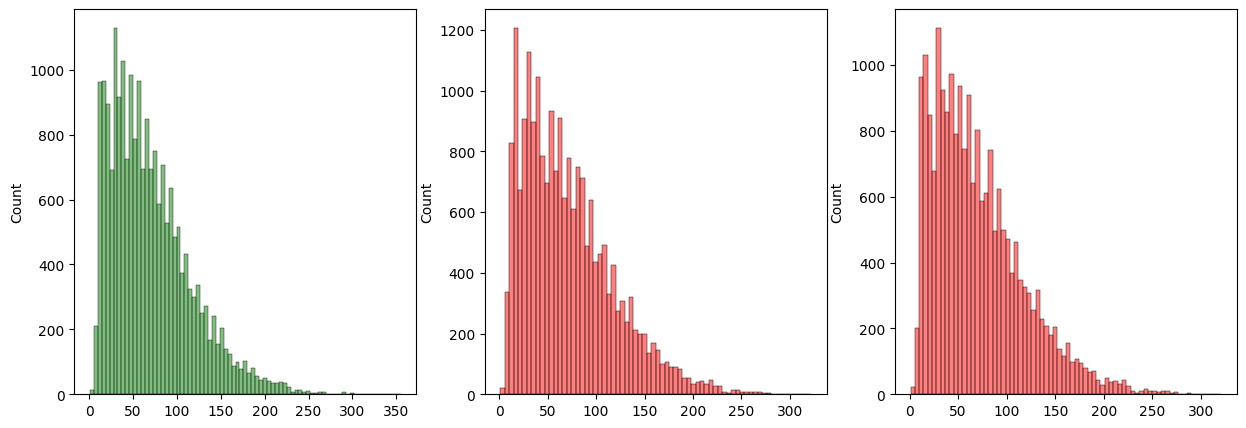

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(ax=axes[0], data=views_A, alpha=0.5, kde=False, color='g')
sns.histplot(ax=axes[1], data=views_B, alpha=0.5, kde=False, color='r')
sns.histplot(ax=axes[2], data=views_B_before, alpha=0.5, kde=False, color='r')

Распределение CTR в сэмплированных выборках для обеих групп:

<Axes: ylabel='Count'>

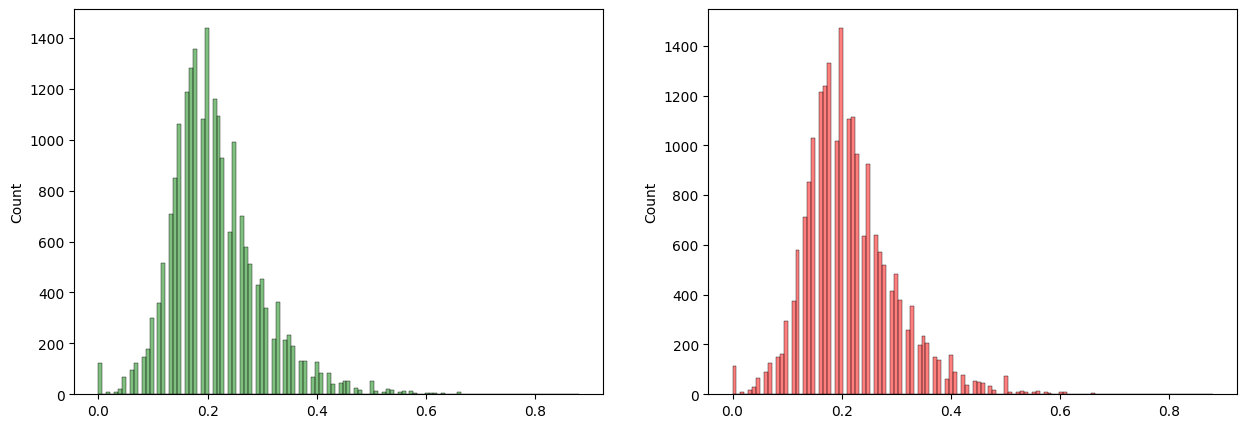

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(ax=axes[0], data=ctr_A, alpha=0.5, kde=False, color='g')
sns.histplot(ax=axes[1], data=ctr_B, alpha=0.5, kde=False, color='r')

Сгенерированное распределение лайков в тестовой и контрольной группах:

<Axes: ylabel='Count'>

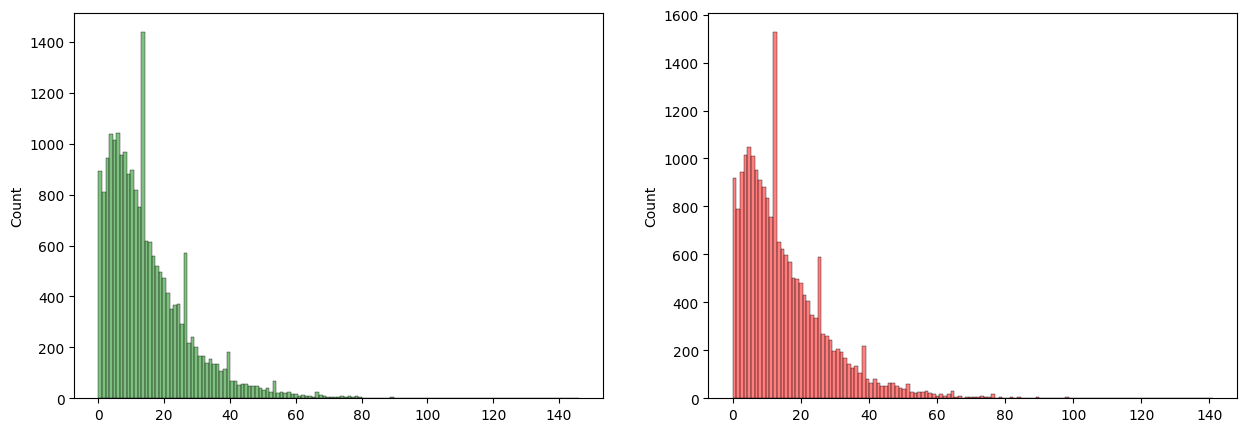

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(ax=axes[0], data=likes_A, alpha=0.5, kde=False, color='g')
sns.histplot(ax=axes[1], data=likes_B, alpha=0.5, kde=False, color='r')